In [177]:
import warnings

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.preprocessing import minmax_scale

In [178]:
df = pd.read_csv("wimbledon.csv")

Compute time spent for each point.

In [179]:
df["elapsed_time_td"] = pd.to_timedelta(df["elapsed_time"])
df["time_diff"] = (
    df.groupby("match_id")["elapsed_time_td"].diff().dt.total_seconds().fillna(0)
)
df[["match_id", "elapsed_time", "time_diff"]]

,match_id,elapsed_time,time_diff
0,2023-wimbledon-1301,00:00:00,0.0
1,2023-wimbledon-1301,00:00:38,38.0
2,2023-wimbledon-1301,00:01:01,23.0
3,2023-wimbledon-1301,00:01:31,30.0
4,2023-wimbledon-1301,00:02:21,50.0
...,...,...,...
7279,2023-wimbledon-1701,04:39:58,27.0
7280,2023-wimbledon-1701,04:40:43,45.0
7281,2023-wimbledon-1701,04:41:20,37.0
7282,2023-wimbledon-1701,04:41:52,32.0


Compute point difference between two players at each point.

In [180]:
df_points_diff = (
    df.groupby(["match_id", "set_no", "game_no"])[["p1_points_won", "p2_points_won"]]
    .apply(lambda x: [entry[0] - entry[1] for entry in x.values])
    .reset_index(name="points_diff_list")
)
df_points_diff

,match_id,set_no,game_no,points_diff_list
0,2023-wimbledon-1301,1,1,"[-1, 0, -1, 0, 1, 0, 1, 0, 1, 2]"
1,2023-wimbledon-1301,1,2,"[1, 2, 3, 2, 1, 2, 1, 0]"
2,2023-wimbledon-1301,1,3,"[1, 2, 1, 2, 3]"
3,2023-wimbledon-1301,1,4,"[2, 1, 0, -1]"
4,2023-wimbledon-1301,1,5,"[0, 1, 2, 1, 0, -1, 0, 1]"
...,...,...,...,...
1183,2023-wimbledon-1701,5,6,"[-1, 0, -1, 0, 1, 2]"
1184,2023-wimbledon-1701,5,7,"[1, 2, 1, 2, 1, 0]"
1185,2023-wimbledon-1701,5,8,"[-1, 0, 1, 2, 3]"
1186,2023-wimbledon-1701,5,9,"[2, 1, 0, 1, 0]"


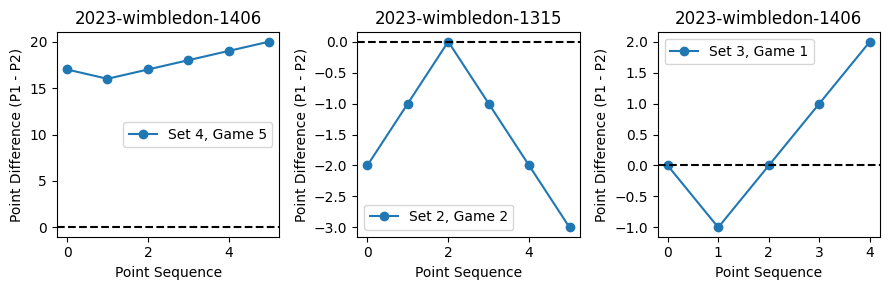

In [181]:
plt.figure(figsize=(9, 3))
for i, (match_id, set_no, game_no, points_diff_list) in df_points_diff.sample(
    3, random_state=0, ignore_index=True
).iterrows():
    plt.subplot(1, 3, i + 1)
    plt.plot(points_diff_list, marker="o", label=f"Set {set_no}, Game {game_no}")
    plt.xlabel("Point Sequence")
    plt.ylabel("Point Difference (P1 - P2)")
    plt.title(match_id)
    plt.axhline(y=0, color="black", linestyle="--")
    plt.legend()
plt.tight_layout()
plt.show()

Select a match to evaluate performance.

In [182]:
match_id = "2023-wimbledon-1301"
match_df = df[df["match_id"] == match_id]

In [183]:
eval_df = match_df.copy()

# Explode the columns to duplicate columns for each player
eval_df["player_id"] = None
for i in eval_df.index:
    eval_df.at[i, "player_id"] = (1, 2)
eval_df = (
    eval_df.explode("player_id")
    .reset_index(names="point_id")
    .set_index(["point_id", "player_id"])
)

# Assign info to the corresponding player
sep_cols = ["ace", "winner", "break_pt_won", "double_fault", "unf_err"]
eval_df_spec_criteria = [True, True, True, False, False]
for col in sep_cols:
    eval_df[col] = eval_df.apply(lambda x: x[f"p{x.name[1]}_{col}"], axis=1)

# Victor by server or receiver
eval_df["victor_by_server"] = eval_df.apply(
    lambda x: int(x["point_victor"] == x.name[1] and x["server"] == x.name[1]), axis=1
)
eval_df["victor_by_receiver"] = eval_df.apply(
    lambda x: int(x["point_victor"] == x.name[1] and x["server"] != x.name[1]), axis=1
)
sep_cols = ["victor_by_server", "victor_by_receiver"] + sep_cols
eval_df_spec_criteria = [True, True] + eval_df_spec_criteria

eval_df_spec = eval_df[sep_cols]
eval_df_spec

victor_by_server  victor_by_receiver  ace  winner  \
point_id player_id                                                      
0        1                         0                   0    0       0   
         2                         0                   1    0       0   
1        1                         1                   0    0       0   
         2                         0                   0    0       0   
2        1                         0                   0    0       0   
...                              ...                 ...  ...     ...   
297      2                         0                   0    0       0   
298      1                         1                   0    0       0   
         2                         0                   0    0       0   
299      1                         1                   0    0       0   
         2                         0                   0    0       0   

                    break_pt_won  double_fault  unf_err  
point_id player_id                                       
0        1                     0             0        1  
         2                     0             0        0  
1        1                     0             0        0  
         2                     0             0        0  
2        1                     0             0        1  
...                          ...           ...      ...  
297      2                     0             0        0  
298      1                     0             0        0  
         2                     0             0        0  
299      1                     0             0        0  
         2                     0             0        0  

[600 rows x 7 columns]

Use the entropy weight method (EWM) to assign the weight for each feature.

In [184]:
scaled_values = minmax_scale(eval_df_spec.values, feature_range=(0.01, 0.99))
norm_values = scaled_values / np.sum(scaled_values, axis=0)
g = 1 + 1 / np.log(len(eval_df_spec)) * np.sum(norm_values * np.log(norm_values), axis=0)
eval_df_spec_weights = g / np.sum(g)
{col: weight for col, weight in zip(eval_df_spec.columns, eval_df_spec_weights)}

{'victor_by_server': 0.08759087046360858,
 'victor_by_receiver': 0.1291685004290725,
 'ace': 0.1819738376659515,
 'winner': 0.13893251745765206,
 'break_pt_won': 0.1488164120563408,
 'double_fault': 0.16593199717316973,
 'unf_err': 0.1475858647542049}

Implement the technique for order of preference by similarity to ideal solution (TOPSIS) for evaluation.

In [185]:
class Topsis:
    def __init__(self, X, weights, criteria):
        self.X = np.asarray(X, dtype="float64")
        self.weights = np.asarray(weights, dtype="float64")
        self.weights /= np.sum(self.weights)
        self.criteria = np.asarray(criteria, dtype=bool)
        self._fitted = False

    def fit(self):
        X_norm = self.X.copy()
        norm_coefs = np.sum(X_norm**2, axis=0) ** 0.5
        X_norm /= norm_coefs
        X_norm *= self.weights

        # Determine the best and worst alternatives
        X_min, X_max = X_norm.min(axis=0), X_norm.max(axis=0)
        best = np.where(self.criteria, X_max, X_min)
        worst = np.where(self.criteria, X_min, X_max)

        # Determine the best and worst distances
        self.best_distance = np.sum((X_norm - best) ** 2, axis=1) ** 0.5
        self.worst_distance = np.sum((X_norm - worst) ** 2, axis=1) ** 0.5
        self._fitted = True

    def predict(self):
        if not self._fitted:
            raise ValueError("The model has not been fitted yet")
        denom = self.best_distance + self.worst_distance
        return self.best_distance / denom, self.worst_distance / denom

    def fit_predict(self):
        if not self._fitted:
            self.fit()
        return self.predict()

In [186]:
topsis = Topsis(eval_df_spec.values, eval_df_spec_weights, eval_df_spec_criteria)
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    eval_df_spec["performance"] = topsis.fit_predict()[1]
eval_df_spec

victor_by_server  victor_by_receiver  ace  winner  \
point_id player_id                                                      
0        1                         0                   0    0       0   
         2                         0                   1    0       0   
1        1                         1                   0    0       0   
         2                         0                   0    0       0   
2        1                         0                   0    0       0   
...                              ...                 ...  ...     ...   
297      2                         0                   0    0       0   
298      1                         1                   0    0       0   
         2                         0                   0    0       0   
299      1                         1                   0    0       0   
         2                         0                   0    0       0   

                    break_pt_won  double_fault  unf_err  performance  
point_id player_id                                                    
0        1                     0             0        1     0.423744  
         2                     0             0        0     0.453471  
1        1                     0             0        0     0.445615  
         2                     0             0        0     0.443012  
2        1                     0             0        1     0.423744  
...                          ...           ...      ...          ...  
297      2                     0             0        0     0.443012  
298      1                     0             0        0     0.445615  
         2                     0             0        0     0.443012  
299      1                     0             0        0     0.445615  
         2                     0             0        0     0.443012  

[600 rows x 8 columns]

In [187]:
p1_performance = eval_df_spec.loc[
    eval_df_spec.index.get_level_values("player_id") == 1, "performance"
]
p2_performance = eval_df_spec.loc[
    eval_df_spec.index.get_level_values("player_id") == 2, "performance"
]
p1_performance.index = p1_performance.index.droplevel("player_id")
p2_performance.index = p2_performance.index.droplevel("player_id")
df_performance = pd.concat([p1_performance, p2_performance], axis=1, keys=["p1", "p2"])
df_performance

,p1,p2
point_id,,
0,0.423744,0.453471
1,0.445615,0.443012
2,0.423744,0.453471
3,0.459815,0.443012
4,0.538465,0.443012
...,...,...
295,0.443012,0.453471
296,0.443012,0.467557
297,0.445615,0.443012


Plot the performance throughout the whole selected match.

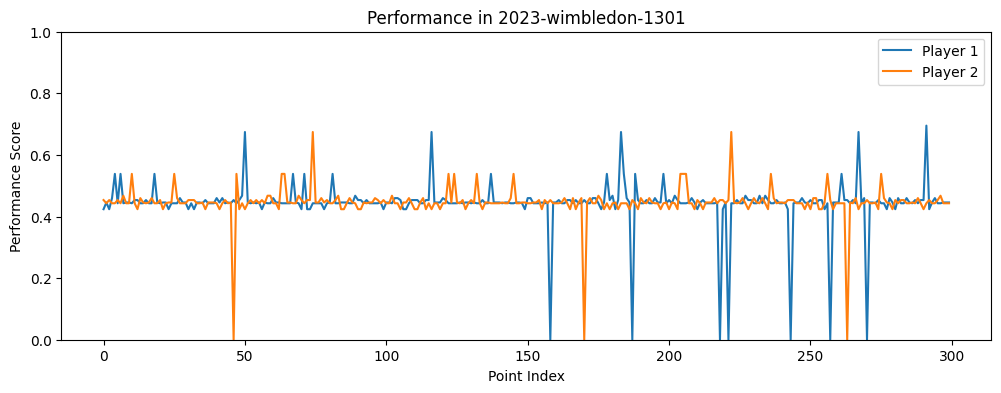

In [188]:
plt.figure(figsize=(12, 4))
plt.plot(df_performance.index, df_performance["p1"], label="Player 1")
plt.plot(df_performance.index, df_performance["p2"], label="Player 2")
plt.xlabel("Point Index")
plt.ylabel("Performance Score")
plt.ylim(0, 1)
plt.title(f"Performance in {match_id}")
plt.legend()
plt.show()

Plot the performance of a selected range of points in the selected match.

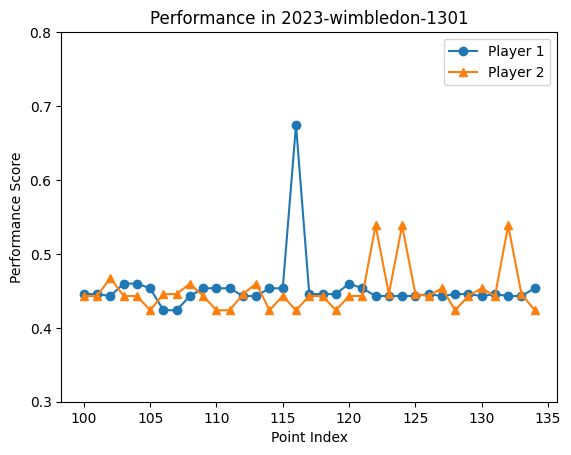

In [189]:
selected_range = list(range(100, 135))
plt.plot(
    selected_range,
    df_performance.loc[selected_range, "p1"],
    label="Player 1",
    marker="o",
)
plt.plot(
    selected_range,
    df_performance.loc[selected_range, "p2"],
    label="Player 2",
    marker="^",
)
plt.xlabel("Point Index")
plt.ylabel("Performance Score")
plt.ylim(0.3, 0.8)
plt.title(f"Performance in {match_id}")
plt.legend()
plt.show()